In [ ]:
# Setup paths and imports - works from any subdirectory
import os
import sys
from pathlib import Path

ROOT = str(Path().resolve().parents[1])
sys.path.append(ROOT)
os.chdir(ROOT)

# For numerics
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

# For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import from various modules
from thesis_code.lfv_lepton_observables.limits import trilepton_decay_limit
from thesis_code.lepton_nucleus_collisions.experiments import EIC
from thesis_code.lfv_lepton_observables.limits import magnetic_dipole_moment_limit
from thesis_code.phys.constants import leptons
from thesis_code.lepton_nucleus_collisions.experiments import E137
from thesis_code.lepton_nucleus_collisions.experiments import MuSIC
from thesis_code.lfv_lepton_observables.limits import trilepton_processes
from thesis_code.lfv_lepton_observables.limits import electric_dipole_moment_limit
from thesis_code.lepton_nucleus_collisions.experiments import FinalState
from thesis_code.lepton_nucleus_collisions.compute.wrappers import default_y
from thesis_code.lfv_lepton_observables.limits import radiative_decay_limit
from thesis_code.lepton_nucleus_collisions.experiments import MuBeD
from thesis_code.lepton_nucleus_collisions.compute.wrappers import default_x
from thesis_code.lfv_lepton_observables.limits import g_2_explanation
from thesis_code.lfv_lepton_observables.limits import radiative_processesfrom thesis_code.phys.constants import ml


# Plots for Presentation

## LFV Lepton Observables

### LFV Lepton Decays

In [3]:
def radiative_label(process):
    i, j = process
    return f'${leptons[i]}\\rightarrow {leptons[j]}\\gamma$'
    
def trilepton_label(process):
    i, j, k, l = process
    return f'${leptons[i]}\\rightarrow {leptons[j]}{leptons[k]}\\bar{{{leptons[l]}}}$'

def radiative_contributes(radiative_process, idx, g = None):
    i, j, k, l = idx
    ii, jj = radiative_process
    if g is None:
        g = np.zeros((3, 3))
        g[i][j] = 1
        g[j][i] = 1
        g[l][k] = 1
        g[k][l] = 1

    return bool(np.sum([g[ii][kk]*g[kk][jj] != 0  for kk in range(3)]))

def tree_level_contributes(trilepton_process, idx, g = None):
    ii, jj, kk, ll = trilepton_process
    i, j, k, l = idx
    
    if g is None:
        g = np.zeros((3, 3))
        g[i][j] = 1
        g[j][i] = 1
        g[l][k] = 1
        g[k][l] = 1

    return bool((g[ii][jj]*g[kk][ll] != 0) + (g[ii][kk] * g[jj][ll] != 0))
    
def plot_limit(m, idx, ax = None, g = None,
               th = [[0]*3]*3, d = [[0]*3]*3, ph = [[0]*3]*3,
               mode = None, ALP = False, Lam = 1000, which = 'radiative', **plot_kwargs):

    if ax == None:
        ax = plt.gca()
    
    i, j, k, l = idx 

    labels = []
    if which == 'radiative':
        for process in radiative_processes:
            limit = radiative_decay_limit(m, process, idx, g, th, d, ph, mode, ALP, Lam)
            if radiative_contributes(process, idx, g = g):            
                ax.plot(m, limit, **plot_kwargs)
                labels.append(radiative_label(process))
    
    if which == 'trilepton':
        for process in trilepton_processes:
            limit = trilepton_decay_limit(m, process, idx, g, th, d, ph, mode, ALP, Lam)
            if tree_level_contributes(process, idx, g = g):
                ax.plot(m, limit, **plot_kwargs)
                labels.append(trilepton_label(process))
    return ax, labels

def plot_limits(m, i, j, ax = None, g = None, ALP = False, Lam = 1000):
    if ax == None:
        ax = plt.gca()
    for k in range(3):
        plot_limit(m, (i, k, k, j), ax = ax, which = 'radiative', g = g, mode = 'PC', ALP = ALP, Lam = Lam, color = colors[k], linewidth = 2)
        plot_limit(m, (i, k, k, j), ax = ax, which = 'radiative', g = g, mode = 'chiral', ALP = ALP, Lam = Lam, color = colors[k], linestyle = 'dashed')
        
        _, labels = plot_limit(m, (i, k, k, j), ax = ax, which = 'trilepton', g = g, mode = 'PC', ALP = ALP, Lam = Lam, color = colors[k], linewidth = 2, alpha = 0.5)
        plot_limit(m, (i, k, k, j), ax = ax, which = 'trilepton', g = g, mode = 'chiral', ALP = ALP, Lam = Lam, color = colors[k], alpha = 0.5, linestyle = 'dashed')

    lines = [line.get_ydata() for line in ax.get_lines()]
    plt.fill_between(m, np.min(lines, axis = 0), 1e3, color = colors[8], alpha = 0.1)
    

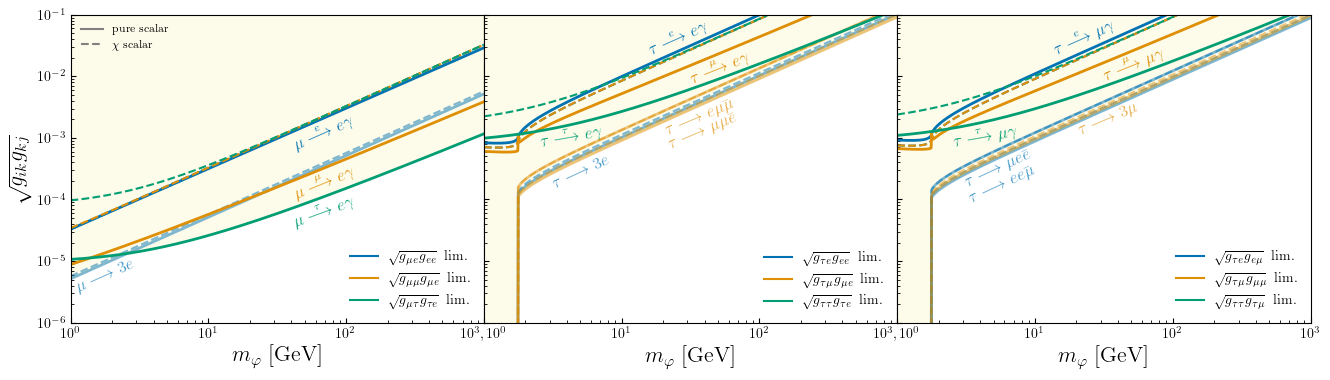

In [4]:
m = np.geomspace(1e0, 1e3, 1000)

fig = plt.figure(figsize = (16, 4))
gs = GridSpec(1, 3, figure = fig, wspace = 0)
axes = []
for idx, process in enumerate([(1, 0), (2, 0), (2, 1)]):
    i, j = process
    ax = fig.add_subplot(gs[idx])
    plot_limits(m, i, j, ax = ax)
    
    ax.tick_params(which = 'both', direction = 'in')
    if idx == 0:
        ax.set_ylabel("$\\sqrt{g_{ik}g_{kj}}$", fontsize = 16)
    ax.set_xlabel("$m_\\varphi~[{\\rm GeV}]$", fontsize = 16)
    
    if idx > 0:
        ax.tick_params(labelleft = False)
        ax.set_ylabel(None)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e0, 1e3)
    ax.set_ylim(1e-6, 1e-1)

    #fix xticks
    xticks = [1e0, 1e1, 1e2] if idx < 2 else [1e0, 1e1, 1e2, 1e3]
    xtick_labels = ["$10^0$", "$10^1$", "$10^2$"] if idx == 0 else ["$10^3, 10^0$", "$10^1$", "$10^2$"]
    if idx == 2:
        xtick_labels += ["$10^3$"]
    ax.set_xticks(xticks, xtick_labels)

    #legends
    plt.plot([0], [1e3], color = 'grey', linestyle = 'solid', label = '$\\textrm{pure scalar}$')
    plt.plot([0], [1e3], color = 'grey', linestyle = 'dashed', label = '$\\chi\\textrm{ scalar}$')
    if idx == 0:
        legend = ax.legend(frameon = False, loc = 'upper left', fontsize = 8)
        ax.add_artist(legend)
    for k in range(3):
        ax.plot([0], [1e3], color = colors[k], label = f'$\\sqrt{{g_{{{leptons[i]} {leptons[k]}}}g_{{{leptons[k]} {leptons[j]}}}}}~~{{\\rm lim.}}$')
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[-3:]
        labels = labels[-3:]
        ax.legend(handles, labels, frameon = False, loc = 'lower right')
    axes.append(ax)

#text 
axes[0].text(40, 6.2e-4, '$\\mu \\stackrel{e}{\\longrightarrow} e\\gamma$', rotation = 24, fontsize = 12, color = colors[0])
axes[0].text(40, 1e-4, '$\\mu \\stackrel{\\mu}{\\longrightarrow} e\\gamma$', rotation = 22, fontsize = 12, color = colors[1])
axes[0].text(40, 3.5e-5, '$\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma$', rotation = 20, fontsize = 12, color = colors[2])
axes[0].text(1.05e0, 3.1e-6, '$\\mu \\longrightarrow 3e$', rotation = 24, fontsize = 12, color = colors[0], alpha = 0.75)

#text 
axes[1].text(15, 2.2e-2, '$\\tau \\stackrel{e}{\\longrightarrow} e\\gamma$', rotation = 24, fontsize = 12, color = colors[0])
axes[1].text(30, 7.4e-3, '$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$', rotation = 22, fontsize = 12, color = colors[1])
axes[1].text(2.5, 7e-4, '$\\tau \\stackrel{\\tau}{\\longrightarrow} e\\gamma$', rotation = 10, fontsize = 12, color = colors[2])
axes[1].text(3, 1.5e-4, '$\\tau \\longrightarrow 3e$', rotation = 25, fontsize = 12, color = colors[0], alpha = 0.75)
axes[1].text(20, 1.1e-3, '$\\tau \\longrightarrow e \\mu\\bar{\\mu}$', rotation = 23, fontsize = 12, color = colors[1], alpha = 0.75)
axes[1].text(21, 6.5e-4, '$\\tau \\longrightarrow \\mu \\mu\\bar{e}$', rotation = 23, fontsize = 12, color = colors[1], alpha = 0.75)

#text 
axes[2].text(13, 2.2e-2, '$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$', rotation = 24, fontsize = 12, color = colors[0])
axes[2].text(30, 8.3e-3, '$\\tau \\stackrel{\\mu}{\\longrightarrow} \\mu\\gamma$', rotation = 22, fontsize = 12, color = colors[1])
axes[2].text(2.5, 7e-4, '$\\tau \\stackrel{\\tau}{\\longrightarrow} \\mu\\gamma$', rotation = 10, fontsize = 12, color = colors[2])
axes[2].text(20, 1.1e-3, '$\\tau \\longrightarrow 3\\mu$', rotation = 23, fontsize = 12, color = colors[1], alpha = 0.75)
axes[2].text(3, 1.55e-4, '$\\tau \\longrightarrow \\mu e \\bar{e}$', rotation = 25, fontsize = 12, color = colors[0], alpha = 0.75)
axes[2].text(3.2, 8.5e-5, '$\\tau \\longrightarrow ee\\bar{\\mu}$', rotation = 25, fontsize = 12, color = colors[0], alpha = 0.75)

plt.savefig('figures/presentation/lfv_scalar_lepton_decay_limits.pdf', format = 'pdf', bbox_inches='tight')

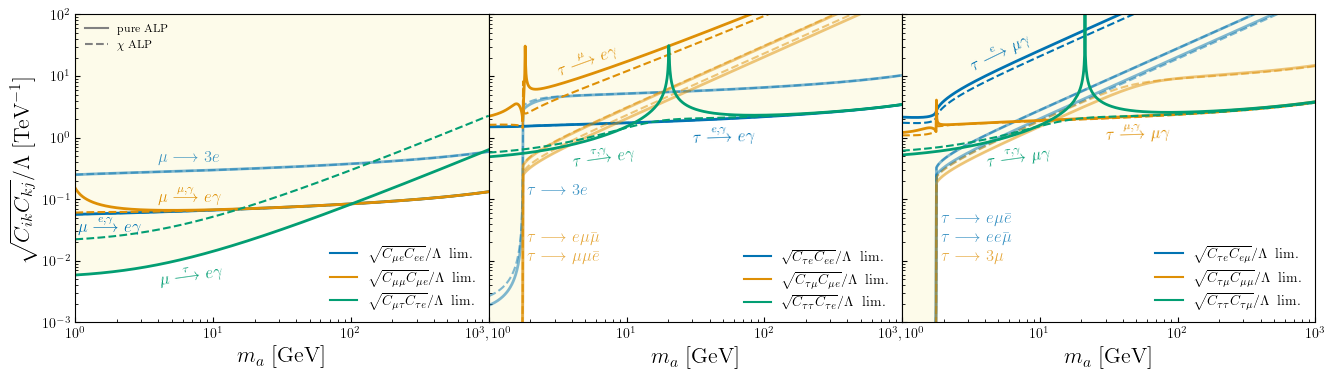

In [5]:
fig = plt.figure(figsize = (16, 4))
gs = GridSpec(1, 3, figure = fig, wspace = 0)

axes = []
for idx, process in enumerate([(1, 0), (2, 0), (2, 1)]):
    i, j = process
    ax = fig.add_subplot(gs[idx])
    plot_limits(m, *process, ax = ax, ALP = 'True', Lam = 10000)
    
    ax.tick_params(which = 'both', direction = 'in')
    if idx == 0:
        ax.set_ylabel("$\\sqrt{C_{ik}C_{kj}}/\\Lambda~[{\\rm TeV}^{-1}]$", fontsize = 16)
    if idx > 0:
        ax.tick_params(labelleft = False)
        ax.set_ylabel(None)
    ax.set_xlabel("$m_a~[{\\rm GeV}]$", fontsize = 16)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e0, 1e3)
    ax.set_ylim(1e-3, 1e2)

    #fix xticks
    xticks = [1e0, 1e1, 1e2] if idx < 2 else [1e0, 1e1, 1e2, 1e3]
    xtick_labels = ["$10^0$", "$10^1$", "$10^2$"] if idx == 0 else ["$10^3, 10^0$", "$10^1$", "$10^2$"]
    if idx == 2:
        xtick_labels += ["$10^3$"]
    ax.set_xticks(xticks, xtick_labels)

    #legends
    plt.plot([0], [1e3], color = 'grey', linestyle = 'solid', label = '$\\textrm{pure ALP}$')
    plt.plot([0], [1e3], color = 'grey', linestyle = 'dashed', label = '$\\chi\\textrm{ ALP}$')
    if idx == 0:
        legend = ax.legend(frameon = False, loc = 'upper left', fontsize = 8)
        ax.add_artist(legend)
    for k in range(3):
        ax.plot([0], [1e3], color = colors[k], label = f'$\\sqrt{{C_{{{leptons[i]} {leptons[k]}}}C_{{{leptons[k]} {leptons[j]}}}}}/\\Lambda~~{{\\rm lim.}}$')
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[-3:]
        labels = labels[-3:]
        ax.legend(handles, labels, frameon = False, loc = 'lower right')
        
    axes.append(ax)

#text 
axes[0].text(1.05, 2.9e-2, '$\\mu \\stackrel{e,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 0, fontsize = 12, color = colors[0])
axes[0].text(4, 0.9e-1, '$\\mu \\stackrel{\\mu,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 0, fontsize = 12, color = colors[1])
axes[0].text(4, 4e-3, '$\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma$', rotation = 8, fontsize = 12, color = colors[2])
axes[0].text(4, 4e-1, '$\\mu \\longrightarrow 3e$', rotation = 0, fontsize = 12, color = colors[0], alpha = 0.75)

#text 
axes[1].text(30, 0.8, '$\\tau \\stackrel{e,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 2, fontsize = 12, color = colors[0])
axes[1].text(3, 10, '$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$', rotation = 20, fontsize = 12, color = colors[1])
axes[1].text(4, 3.3e-1, '$\\tau \\stackrel{\\tau,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 8, fontsize = 12, color = colors[2])
axes[1].text(1.9, 1.2e-1, '$\\tau \\longrightarrow 3e$', fontsize = 12, color = colors[0], alpha = 0.75)
axes[1].text(1.9, 2e-2, '$\\tau \\longrightarrow e \\mu\\bar{\\mu}$', fontsize = 12, color = colors[1], alpha = 0.75)
axes[1].text(1.9, 1e-2, '$\\tau \\longrightarrow \\mu \\mu\\bar{e}$', fontsize = 12, color = colors[1], alpha = 0.75)

#text 
axes[2].text(3, 12, '$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$', rotation = 26, fontsize = 12, color = colors[0])
axes[2].text(30, 0.9, '$\\tau \\stackrel{\\mu,\\gamma}{\\longrightarrow} \\mu\\gamma$', rotation = 2, fontsize = 12, color = colors[1])
axes[2].text(4, 3.3e-1, '$\\tau \\stackrel{\\tau,\\gamma}{\\longrightarrow} \\mu\\gamma$', rotation = 8, fontsize = 12, color = colors[2])
axes[2].text(1.9, 4e-2, '$\\tau \\longrightarrow e\\mu \\bar{e}$', fontsize = 12, color = colors[0], alpha = 0.75)
axes[2].text(1.9, 2e-2, '$\\tau \\longrightarrow ee\\bar{\\mu}$', fontsize = 12, color = colors[0], alpha = 0.75)
axes[2].text(1.9, 1e-2, '$\\tau \\longrightarrow 3\\mu$', fontsize = 12, color = colors[1], alpha = 0.75)

plt.savefig('figures/presentation/lfv_alp_lepton_decay_limits.pdf', format = 'pdf', bbox_inches='tight')

### Dipole Moments

In [7]:
def plot_EDM_limit(m, i, idx, ax = None,
                   g = None, th = [[0]*3]*3, d = [[0]*3]*3, ph = [[0]*3]*3, mode = None, ALP = False, Lam = 10000,
                   **plot_kwargs):
    _i, _j = idx
    limit = electric_dipole_moment_limit(m, i, (_i, _j), g, th, d, ph, mode, ALP, Lam)

    plt.plot(m, limit, **plot_kwargs)

def plot_EDM_limits(m, i, ax = None, g = None, th = [[0]*3]*3, d = [[0]*3]*3, ph = [[0]*3]*3, ALP = False, Lam = 10000):
    if not ax:
        ax = plt.gca()
    
    particle = 'ALP' if ALP else 'scalar'

    #PC plots
    for j in range(3):
        plot_EDM_limit(m, i, (i, j), ax, g, th, d, ph, 'max CPV', ALP, Lam, color = colors[j])

    minimum = np.min([line.get_ydata() for line in ax.get_lines()], axis = 0)
    ax.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.1)

    for j in range(3):
        plt.plot([1], [1e3], color = colors[j],
                 label = f'$C_{{{leptons[i]} {leptons[j]}}}/\\Lambda~\\textrm{{lim.}}$' if ALP else f'$g_{{{leptons[i]} {leptons[j]}}}~\\textrm{{lim.}}$')

    ax.legend(frameon = False,
              fontsize = 10,
              loc = 'lower right')

    ax.tick_params(direction = 'in', which = 'both')

    ax.set_xscale('log')
    
    ax.set_xlim(1e0, 1e3)
    ax.set_xlabel("$m_a~[\\textrm{GeV}]$" if ALP else "$m_\\varphi~[\\textrm{GeV}]$", fontsize = 14)

    ax.set_yscale('log')
    ymin, ymax =  [1e-4 if ALP else 1e-7, 1e2 if ALP else 1e-1]
    ax.set_ylim(ymin, ymax)
    ALP_label = f'$C_{{{leptons[i]} \\ell}}\\sqrt{{\\sin{{2\\Theta_{{{leptons[i]} \\ell}}}}\\sin{{\\Delta_{{{leptons[i]} \\ell}}}}}}/\\Lambda~[{{\\rm TeV}}]^{{-1}}$'
    scalar_label = f'$g_{{{leptons[i]} \\ell}}\\sqrt{{\\sin{{2\\theta_{{{leptons[i]} \\ell}}}}\\cos{{\\delta_{{{leptons[i]} \\ell}}}}}}$'
    ylabel =ALP_label if ALP else scalar_label
    ax.set_ylabel(ylabel, fontsize = 14)
    
    return ax

In [8]:
def plot_MDM_limit(m, i, idx, ax = None,
                   g = None, th = [[0]*3]*3, d = [[0]*3]*3, ph = [[0]*3]*3, mode = None, ALP = False, Lam = 10000,
                   **plot_kwargs):
    _i, _j = idx
    limit = magnetic_dipole_moment_limit(m, i, (_i, _j), g, th, d, ph, mode, ALP, Lam)
    plt.plot(m, limit, **plot_kwargs)

def plot_MDM_limits(m, i, ax = None, g = None, th = [[0]*3]*3, d = [[0]*3]*3, ph = [[0]*3]*3, ALP = False, Lam = 10000):
    if not ax:
        ax = plt.gca()
    
    particle = 'ALP' if ALP else 'scalar'

    #PC plots
    for j in range(3):
        plot_MDM_limit(m, i, (i, j), ax, g, th, d, ph, 'PC', ALP, Lam, color = colors[j])
        plot_MDM_limit(m, i, (i, j), ax, g, th, d, ph, 'chiral', ALP, Lam, color = colors[j], linestyle = 'dashed')

    minimum = np.min([line.get_ydata() for line in ax.get_lines()], axis = 0)
    ax.fill_between(m, minimum, 1e3, color = 'yellow', alpha = 0.1)

    for j in range(3):
        plt.plot([1], [1e3], color = colors[j],
                 label = f'$C_{{{leptons[i]} {leptons[j]}}}/\\Lambda~\\textrm{{lim.}}$' if ALP else f'$g_{{{leptons[i]} {leptons[j]}}}~\\textrm{{lim.}}$')

    legend = ax.legend(frameon = False,
                       fontsize = 10,
                       loc = 'lower right')
    ax.add_artist(legend)
    
    #This is only for the first plot
    ax.plot([1000], color = 'grey', label = f'$\\textrm{{pure {particle}}}$')
    ax.plot([1000], color = 'grey', label = f'$\\chi\\textrm{{ {particle}}}$', linestyle = 'dashed')

    particle_handles, particle_labels = ax.get_legend_handles_labels()
    particle_handles, particle_labels = particle_handles[-2:], particle_labels[-2:]

    ax.legend(particle_handles, particle_labels,
              frameon = False,
              fontsize = 8,
              loc = 'upper left')

    ax.tick_params(direction = 'in', which = 'both')

    ax.set_xscale('log')
    
    ax.set_xlim(1e0, 1e3)
    if ALP:
        ax.set_xlabel("$m_a~[\\textrm{GeV}]$", fontsize = 14)
    else:
        ax.set_xlabel("$m_\\varphi~[\\textrm{GeV}]$", fontsize = 14)

    ax.set_yscale('log')
    ymin, ymax =  [1e-1 if ALP else 1e-4, 1e3 if ALP else 1e0]
    ax.set_ylim(ymin, ymax)

    ylabel =f'$C_{{{leptons[i]} \\ell}}/\\Lambda~[{{\\rm TeV}}]^{{-1}}$' if ALP else f'$g_{{{leptons[i]} \\ell}}$'
    ax.set_ylabel(ylabel, fontsize = 14)
    
    return ax

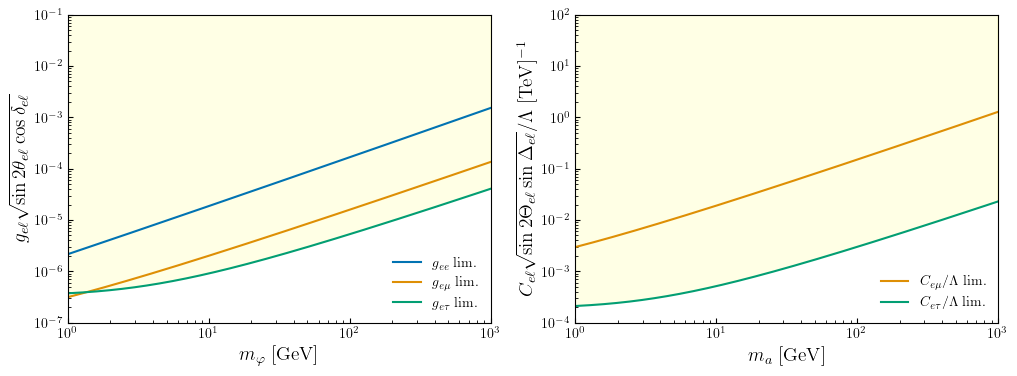

In [9]:
m = np.geomspace(1, 1e3, 1000)

fig = plt.figure(figsize = (12, 4))
gs = GridSpec(1, 2, figure = fig, wspace = 0.2)

ax = fig.add_subplot(gs[0])
plot_EDM_limits(m, 0, ax = ax)

ax = fig.add_subplot(gs[1])
plot_EDM_limits(m, 0, ax = ax, ALP = True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], frameon = False, loc = 'lower right')

plt.savefig('figures/presentation/lfv_edm_limits.pdf', format = 'pdf', bbox_inches='tight')

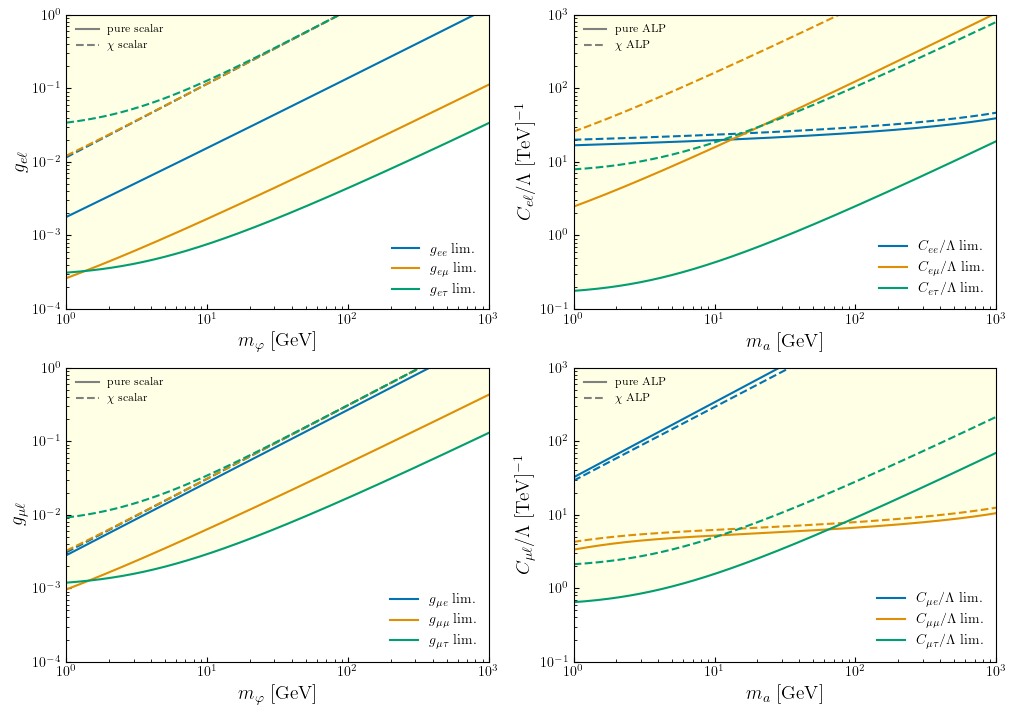

In [10]:
fig = plt.figure(figsize = (12, 8.4))
gs = GridSpec(2, 2, figure = fig, hspace = 0.2, wspace = 0.2)

for i in range(2):
    ax = fig.add_subplot(gs[2*i])
    plot_MDM_limits(m, i, ax = ax)

    ax = fig.add_subplot(gs[2*i+1])
    plot_MDM_limits(m, i, ax = ax, ALP = True, Lam = 10000)
    
plt.savefig('figures/presentation/lfv_mdm_limits.pdf', format = 'pdf', bbox_inches='tight')

## Lepton Nucleus Collisions

### Total production cross-section

In [ ]:
def plot_crossx(masses, experiment, params, PV_angle = None, ax = None, color = None, linestyle = 'solid', line_alpha = 1, fill_alpha = 1, units = 'pb', label = None):
    if not ax:
        ax = plt.gca()
    if not color:
        color = color_dict[experiment]

    final_states = np.array([FinalState(*params, m, PV_angle) for m in masses])
    crossx = np.array([experiment.cross_section(final_state, units = units, interpolate_mass = True) for final_state in final_states])

    if not PV_angle:

        ax.fill_between(masses,
                        crossx[:,0],
                        crossx.sum(axis = 1),
                        color = color,
                        alpha = fill_alpha)
        
        ax.plot(masses,
                crossx[:, 0],
                color = color,
                linestyle = linestyle,
                alpha = line_alpha,
                label = label)

        plot_PV = np.abs((crossx[:, 1])/crossx[:, 0]) > 0.05

        ax.plot(masses[plot_PV],
                crossx.sum(axis = 1)[plot_PV],
                color = color,
                linestyle = linestyle,
                alpha = line_alpha)
    else:
        ax.plot(masses, 
                crossx[:,0]+np.sin(PV_angle)**2 * crossx[:, 1],
                color = color,
                linestyle = linestyle,
                alpha = line_alpha)

def plot_each_lepton(experiment, boson_type, method = 'exact', t_cut_off = 1.0, masses = None, PV_angle = None, ax = None, color = None, units = 'pb'):
    if not ax:
        ax = plt.gca()
    linestyle = ['solid', 'dashed', 'dotted']
    
    use_cached_masses = masses is None
    
    for idx, lepton in enumerate(['e', 'mu', 'tau']):
        if use_cached_masses:
            masses = experiment.cached_masses(method, t_cut_off, lepton, boson_type)
        plot_crossx(masses, 
                    experiment,
                    (method, t_cut_off, lepton, boson_type),
                    PV_angle = PV_angle,
                    ax = ax,
                    color = color,
                    linestyle = linestyle[idx],
                    fill_alpha = 0.2,
                    units = units)

def compare_particle_types(experiments,
                           ax1,
                           ax2,
                           t_cut_off = 1.0,
                           method = 'exact',
                           masses = None,
                           ylim = (1e0,1e14),
                           xlim = (1e-3,2e2),
                           units = 'pb'):
    
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")

    params = {'boson_type': 'scalar',
              't_cut_off': t_cut_off,
              'method': method}

    for experiment in experiments:
        plot_each_lepton(experiment, masses = masses, ax = ax1, **params)
        # Make legend handle/label
        ax1.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
        
    ax2.set_title("$\\textrm{(Axial-)Vector}$")

    params = {'boson_type': 'vector',
              't_cut_off': t_cut_off,
              'method': method}
    
    for experiment in experiments:
        plot_each_lepton(experiment, masses = masses, ax = ax2, **params)
        # Make legend handle/label
        ax2.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
    
    
    li = experiment.lepton
    li = li if li == 'e' else f'\\{li}'
    
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow \\ell^- A_Z \\varphi)/g_{{{li}\\ell}}^2~[{{\\rm {units}}}]$')
    ax1.tick_params(which = 'both', direction = 'in')
    ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

    axes = [ax1, ax2]
    for ax in axes:
        ax.grid()
        
        ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        if ylim:
            ax.set_ylim(*ylim)
        if xlim:
            ax.set_xlim(*xlim)
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'solid',
                label = "$\\ell = e$")
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'dashed',
                label = "$\\ell = \\mu$")
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'dotted',
                label = "$\\ell = \\tau$")
        
        ax.legend(fancybox = False,
                  facecolor = 'white',
                  edgecolor = 'black',
                  framealpha = 1,
                  loc = 'upper right',
                  fontsize = 8,
                  borderpad = 0.6)
    return ax1, ax2

In [ ]:
fig = plt.figure(figsize = (10, 7))
gs = GridSpec(2, 2, wspace = 0.1, hspace = 0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax1, ax2 = compare_particle_types([E137, EIC], ax1, ax2)
ax3, ax4 = compare_particle_types([MuBeD, MuSIC], ax3, ax4)
ax3.set_title(None)
ax4.set_title(None)

plt.savefig('figures/presentation/production_crossx.pdf', format = 'pdf', bbox_inches = 'tight')

### Validity of the Weizsacker-Williams approximation

In [ ]:
def relative_error(exact, approx):
    return np.abs(approx - exact)/np.abs(exact)

def plot_methods(experiment,
                 lepton,
                 particle_type,
                 t_cut_off = 1.0,
                 masses = None,
                 color = None,
                 ax = None,
                 units = 'pb'):
    if not ax:
        ax == plt.gca() 

    if not color:
        color = color_dict[experiment]

    use_cached_masses = masses is None
                
    linestyle = ['solid', 'dashed', 'dotted']
    for idx, method in enumerate(['exact', 'WW', 'IWW']):
        params = (method, t_cut_off, lepton, particle_type)
        if use_cached_masses:
            masses = experiment.cached_masses(*params)
        plot_crossx(masses,
                    experiment,
                    params,
                    ax = ax,
                    color = color,
                    linestyle = linestyle[idx],
                    fill_alpha = 0.2 if method=='exact' else 0.0,
                    units = units)
        
def plot_method_errors(experiment,
                       lepton,
                       particle_type,
                       t_cut_off = 1.0,
                       masses = None,
                       ax = None,
                       color = None):
    if not ax:
        ax = plt.gca()
    
    if not color:
        color = color_dict[experiment]

    params = (t_cut_off, lepton, particle_type)
    
    use_cached_masses = masses is None
    if use_cached_masses:
        masses = experiment.cached_masses('exact', *params)
        
    params = (t_cut_off, lepton, particle_type)
    final_states = [FinalState('exact', *params, m) for m in masses]
    crossx_exact = np.array([experiment.cross_section(final_state) for final_state in final_states]).transpose()
    crossx_exact[1] = crossx_exact[0] + crossx_exact[1]

    for linestyle, method in zip(['dashed', 'dotted'], ['WW', 'IWW']):
        final_states = [FinalState(method, *params, m) for m in masses]
        crossx_approx = np.array([experiment.cross_section(final_state) for final_state in final_states]).transpose()
        crossx_approx[1] = crossx_approx[0] + crossx_approx[1]

        ax.plot(masses, relative_error(crossx_exact[0], crossx_approx[0]), color = color, linestyle = linestyle)
        ax.plot(masses, relative_error(crossx_exact[1], crossx_approx[1]), color = color, linestyle = linestyle)
    
def compare_methods(experiments,
                    lepton,
                    gs, #Input GridSpec rather than axes, so that the error plots can be generated
                    t_cut_off = 1.0,
                    masses = None,
                    ylim = (1e0,1e14),
                    error_ylim = (1e-6, 1e0),
                    xlim = (1e-3,1e2),
                    units = 'pb'):
        
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[2], sharex = ax1)
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")
    params = (lepton, 'scalar', t_cut_off)
    for experiment in experiments:
        plot_methods(experiment, *params, masses = masses, ax = ax1)
        plot_method_errors(experiment, *params, masses = masses, ax = ax2)
        ax1.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
        
    ax3 = fig.add_subplot(gs[1])
    ax4 = fig.add_subplot(gs[3], sharex = ax3)
    ax3.set_title("$\\textrm{(Axial-)Vector}$")
    
    params = (lepton, 'vector', t_cut_off)        
    for experiment in experiments:
        plot_methods(experiment, *params, masses = masses, ax = ax3)
        plot_method_errors(experiment, *params, masses = masses, ax = ax4)
        ax3.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
    
    ax1.tick_params(which = 'both', direction = 'in', labelbottom = False)
    ax2.tick_params(which = 'both', direction = 'in')
    ax3.tick_params(which = 'both', direction = 'in', labelbottom = False, labelleft = False)
    ax4.tick_params(which = 'both', direction = 'in', labelleft = False)
    
    li = experiment.lepton
    li = li if li == 'e' else f'\\{li}'
    lf = lepton if lepton == 'e' else f'\\{lepton}'
    
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow {lf}^- A_Z \\varphi)/g_{{{li}{lf}}}^2~[{{\\rm {units}}}]$')
    ax2.set_ylabel('$\\textrm{rel. error}$')

    axes = [ax1, ax2, ax3, ax4]
    for idx, ax in enumerate(axes):
        ax.grid()
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if idx%2 == 0:
            if ylim:
                ax.set_ylim(*ylim)
                
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'solid',
                    label = "$\\textrm{exact}$")
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'dashed',
                    label = "$\\textrm{WW}$")
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'dotted',
                    label = "$\\textrm{IWW}$")
        
            ax.legend(fancybox = False,
                      facecolor = 'white',
                      edgecolor = 'black',
                      framealpha = 1,
                      loc = 'upper right',
                      fontsize = 8,
                      borderpad = 0.6)
            
        if idx%2 == 1:
            if error_ylim:
                ax.set_ylim(*error_ylim)
            if xlim:
                ax.set_xlim(*xlim)
            ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')            
            
    return axes

In [ ]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods([E137, EIC], 'e', sub_gs)
ax1.set_yticks([1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e3, 1e6, 1e9, 1e12])

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods([MuBeD, MuSIC], 'mu', sub_gs)
ax5.set_yticks([1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e3, 1e6, 1e9, 1e12])
ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/presentation/crossx_approximations_diagonal.pdf', bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods([E137, EIC], 'tau', sub_gs)
ax1.set_yticks([1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e3, 1e6, 1e9, 1e12])

ax2.set_ylim(1e-6, 1e2)
ax4.set_ylim(1e-6, 1e2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods([MuBeD, MuSIC], 'tau', sub_gs)
ax5.set_yticks([1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e3, 1e6, 1e9, 1e12])

ax6.set_ylim(1e-6, 1e2)
ax8.set_ylim(1e-6, 1e2)

ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/presentation/crossx_approximations_tau.pdf', bbox_inches = 'tight')

### $\varphi$ Kinematical Distributions

In [ ]:
def envelope(distributions):
    return np.nanmax(distributions, axis = 0)

def smooth(y, window = 10):
    y_new = np.ones(len(y) + window)
    y_new[window//2:-window//2] = y
    y_new[:window//2] = y[0]
    y_new[-window//2:] = y[-1]
    return np.convolve(y_new, np.ones(window)/window, mode = 'same')[window//2:-window//2]

# custom smooth function for the envelope...
def env_smooth(y, window = 10, clip = True):
    log_grad = np.gradient(np.log(y))
    log_grad = np.where(np.isfinite(log_grad), log_grad, 0)
    idcs = np.where(np.abs(np.diff(np.sign(log_grad))) == 2)[0]
    y_new = np.copy(y)
    if len(idcs) > 0:
        start = idcs[0]
        stop = idcs[-1] + 1
        kernel = np.ones(window)/window

        if len(y_new[start:stop]) < window:
            window = len(y_new[start:stop])
        y_new[start:stop] = smooth(y_new[start:stop], window = window)

    # if clip, then need to find regions where the difference between
    # neighboring points exceeds a certain tolerance (1% here)
    if clip:
        ratio = (np.roll(y, 1) + np.roll(y, -1))/(2*y)
        clip_region = np.where(np.abs(ratio - 1) > 0.01)[0]
        clip_region = clip_region[(clip_region > 0)*(clip_region < len(y)-1)]
        if len(clip_region) > 0:
        # clip region might have neighboring points. To deal with this, we 
        # find the indices which correspond to the start and stop of a 
        # "region" of neighboring points.
            split = np.where(np.diff(clip_region) != 1)[0] + 1
            blocks = np.split(clip_region, split)
            clip_start = np.concatenate([[block[0]-1]*len(block) for block in blocks])
            clip_stop = np.concatenate([[(block[-1]+1)%len(y)]*len(block) for block in blocks])
            y_new[clip_region] = (y[clip_start] + y[clip_stop])/2
    
    return y_new

In [ ]:
def plot_distributions(experiment, params, x_min, x_max, masses = None, PV_angle = 0, ax = None, color = None, frame = 'lab', particle = 'boson', n_pts = 1000, scale = 'lin', which = 'y', var = 'eta', smooth_dist = True, dist_window = 20, smooth_env = True, env_window = 10, clip = False):

    if not ax:
        ax = plt.gca()

    if not color:
        color = color_dict[experiment]
    
    if masses is None:
        masses = experiment.cached_masses(*params)

    final_states =[FinalState(*params, m, PV_angle) for m in masses]
                 
    if scale == 'lin':
        x = np.linspace(x_min, x_max, n_pts)
    else:
        x = np.geomspace(x_min, x_max, n_pts)

    if which == 'x':
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, x = x, x_var = var, frame = frame, particle = particle) for final_state in tqdm(final_states)]))
    else:
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, y = x, y_var = var, frame = frame, particle = particle) for final_state in tqdm(final_states)]))
    non_zero = np.where(dists.sum(axis = 1) != 0)[0]
    if len(non_zero) == 0:
        min_idx = 0
        max_idx = -1
    else:
        min_idx = non_zero[0]
        max_idx = non_zero[-1]

    if smooth_dist:
        dists = np.array([smooth(dist, window = dist_window) for dist in dists])
    
    env = envelope(dists)
    #ax.plot(x, env)
    if smooth_env:
        env = env_smooth(env, window = env_window, clip = clip)
    ax.plot(x, dists[min_idx], color = color)
    ax.plot(x, dists[max_idx], color = color)
    ax.plot(x, env, color = color, linestyle = 'dotted', alpha = 0.5)
    ax.fill_between(x, env, color = color, alpha = 0.2)

    return masses[min_idx], masses[max_idx]

### $\varphi$ pseudo-rapidity distributions

In [ ]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

params = ('exact', 1.0, 'e', 'scalar')

masses = E137.cached_masses(*params)
masses = np.geomspace(masses.min(), masses.max(), 100)[:-4]

print('-----------------E137-----------------')
plot_distributions(E137, params, 0, 15, frame = 'lab', masses = masses, which = 'y', var = 'eta', env_window = 1)
print('-----------------EIC-----------------')
plot_distributions(EIC, params, 0, 15, frame = 'lab', masses = masses, which = 'y', var = 'eta', env_window = 1)

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (11, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (12.1, 0.5),
             xy = (11.2, 0.4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (0.5, 0.52),
             xy = (2.5, 0.32),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (2.2, 0.5),
             xy = (4, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\eta$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)

ax1.set_xlim(0, 15)
ax1.set_ylim(0, 0.8)
ax1.grid()

ax2 = fig.add_subplot(gs[1])

params = ('exact', 1.0, 'mu', 'scalar')

masses = np.geomspace(1e-3, 40, 100)

print('-----------------MuBeD-----------------')
plot_distributions(MuBeD, params, 0, 15, frame = 'lab', masses = masses, which = 'y', var = 'eta', env_window = 1)

print('-----------------MuSIC-----------------')
plot_distributions(MuSIC, params, 0, 15, frame = 'lab', masses = masses, which = 'y', var = 'eta', env_window = 1)

ax2.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (10.3, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))
ax2.annotate('',
             xytext = (11.9, 0.5),
             xy = (10.4, 0.42),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))


ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (2.5, 0.52),
             xy = (4.4, 0.38),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (4.4, 0.5),
             xy = (7.2, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\eta$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)

ax2.set_xlim(0, 15)
ax2.set_ylim(0, 0.8)
ax2.grid()

plt.savefig('figures/presentation/eta_distributions_diagonal.pdf', format = 'pdf', bbox_inches = 'tight')

### $\varphi$ boost distributions

In [ ]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

params = ('exact', 1.0, 'e', 'scalar')
masses = E137.cached_masses(*params)
masses = np.geomspace(masses.min(), masses.max(), 100)[:-4]

print('-----------------E137-----------------')
plot_distributions(E137, params, 1e0, 1e6, scale = 'log', frame = 'lab', masses = masses, which = 'x', var = 'gamma', env_window = 1)
print('-----------------EIC-----------------')
plot_distributions(EIC, params, 1e0, 1e6, scale = 'log', frame = 'lab', masses = masses, which = 'x', var = 'gamma', env_window = 1)


ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (600, 5e-4),
             xy = (1.5e4, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (3.2e3, 3.7e-4),
             xy = (1.5e4, 6e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (10.2, 5e-4),
             xy = (2, 1e-2),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (18, 3e-4),
             xy = (2.7, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))


ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\gamma$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.95, 2e4)
ax1.set_ylim(1e-6, 1e1)

ax2 = fig.add_subplot(gs[1])

params = ('exact', 1.0, 'mu', 'scalar')

masses = np.geomspace(1e-3, 40, 100)

print('-----------------MuBeD-----------------')
plot_distributions(MuBeD, params, 1e0, 1e6, scale ='log', frame = 'lab', masses = masses, which = 'x', var = 'gamma', env_window = 1)
print('-----------------MuSIC-----------------')
plot_distributions(MuSIC, params, 1e0, 1e6, scale = 'log', frame = 'lab', masses = masses, which = 'x', var = 'gamma', env_window = 1)

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (1.7e4, 5e-4),
             xy = (1.5e4, 1e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (7.3e4, 3.5e-4),
             xy = (4e4, 6e-6),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (73, 5e-4),
             xy = (14, 5e-3),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (170, 3e-4),
             xy = (24, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))


ax2.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\gamma$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax2.grid()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1e-6, 1e1)

plt.savefig('figures/presentation/gamma_distributions_diagonal.pdf', format = 'pdf', bbox_inches = 'tight')

### Median Kinematical Distributions

In [ ]:
def plot_medians(experiment, params, masses = None, PV_angle = 0, ax = None, color = None, frame = 'lab', particle = 'boson', n_pts = 1000, which = 'y', var = 'eta'):

    if not ax:
        ax = plt.gca()

    if not color:
        color = color_dict[experiment]
    
    if masses is None:
        masses = experiment.cached_masses(*params)

    final_states =[FinalState(*params, m, PV_angle) for m in masses]

    if which == 'x':
        xs = np.array([default_x(experiment, final_state, frame = frame, particle = particle, n_pts = n_pts, x_var = var) for final_state in final_states])
    else:
        xs = np.array([default_y(n_pts = n_pts, y_var = var) for final_state in final_states])

    if which == 'x':
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, x = x, x_var = var, frame = frame, particle = particle) for x, final_state in zip(xs, tqdm(final_states))]))
    else:
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, y = x, y_var = var, frame = frame, particle = particle) for x, final_state in zip(xs, tqdm(final_states))]))


    y_tots = np.trapezoid(dists, x = xs, axis = -1).reshape(-1, 1)
    
    y_ints = np.array([np.trapezoid(dists[:, :idx]/y_tots, x = xs[:, :idx], axis = -1) for idx in range(len(xs[0]))]).T

    x_50 = smooth(np.array([np.interp(0.5, y_ints[idx], xs[idx]) for idx in range(len(xs))]), window = 10)
    x_25 = smooth(np.array([np.interp(0.25, y_ints[idx], xs[idx]) for idx in range(len(xs))]), window = 10)
    x_75 = smooth(np.array([np.interp(0.75, y_ints[idx], xs[idx]) for idx in range(len(xs))]), window = 10)

    if np.any(np.isnan(x_50).sum() > 0):
        endpt = np.min(np.where(np.isnan(x_50))) - 1
    else:
        endpt = -1

    ax.fill_between(masses, x_25, x_75, color = color, alpha = 0.1)
    ax.plot(masses, x_25, color = color)
    ax.plot(masses, x_75, color = color)
    ax.plot(masses, x_50, color = color, linestyle = 'dotted', alpha = 0.5)
    
    #connect the edges
    xmin = x_25[endpt]
    xmax = x_75[endpt]
    ax.plot([masses[endpt], masses[endpt]], [xmin, xmax], color = color)

    ax.tick_params(which = 'both', direction = 'in')
    
    return ax    

### $\varphi$ pseudo-rapidity distribution

In [ ]:
frame = 'lab'
particle = 'boson'
which = 'y'
var = 'eta'

fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

print('---------------l A_Z -> l A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, experiment.lepton, 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)
    
ax1.text(2.1, 10.4, '$\\theta = m_\\ell / E_\\ell$', color = 'black')
ax1.annotate('', (40, 9.8), (22, 10.65),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (40, 11.3), (22, 10.52),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax1.axhline(-np.log(np.tan(5.11e-4/(2*20))), color = 'black', linestyle = 'dashed')
ax1.axhline(-np.log(np.tan(0.106/(2*1000))), color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\eta_\\varphi$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(0, 12)

ax2 = fig.add_subplot(gs[1])

print('---------------l A_Z -> tau A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, 'tau', 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)
    
ax2.text(2.1e-3, 5, '$\\theta = m_\\tau / E_\\ell$', color = 'black')
ax2.annotate('', (4e-2, 3.1), (2.4e-2, 5.27),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (4e-2, 7), (2.4e-2, 5.10),
             arrowprops = dict(arrowstyle = '->', color = 'black'))


ax2.axhline(-np.log(np.tan(1.77/(2*20))), color = 'black', linestyle = 'dashed')
ax2.axhline(-np.log(np.tan(1.77/(2*1000))), color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\eta_\\varphi$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')

ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(0, 12)

plt.savefig('figures/presentation/average_eta.pdf', format = 'pdf', bbox_inches = 'tight')

### $\varphi$ boost distributions

In [ ]:
frame = 'lab'
particle = 'boson'
which = 'x'
var = 'gamma'

fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

print('---------------l A_Z -> l A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, experiment.lepton, 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)
    
#ax1.text(2.1, 20, '$\\gamma = E_\\ell / m_\\ell$', color = 'black')
ax1.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

x = np.geomspace(1e-3, 200, 1000)

ax1.plot(x, 20/x, color = 'black', linestyle = 'dashed')
ax1.plot(x, 1000/x, color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\gamma_\\ell$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(1e0, 1e6)

ax2 = fig.add_subplot(gs[1])

print('---------------l A_Z -> tau A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, 'tau', 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)


ax2.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax2.plot(x, 20/x, color = 'black', linestyle = 'dashed')
ax2.plot(x, 1000/x, color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\gamma_\\tau$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(1e0, 1e6)

plt.savefig('figures/presentation/average_gamma.pdf', format = 'pdf', bbox_inches = 'tight')

### $\ell$ pseudo-rapidity distribution

In [ ]:
frame = 'lab'
particle = 'lepton'
which = 'y'
var = 'eta'

fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

print('---------------l A_Z -> l A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, experiment.lepton, 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\eta_\\ell$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(-1.9, 12)


ax2 = fig.add_subplot(gs[1])

print('---------------l A_Z -> tau A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, 'tau', 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\eta_\\tau$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')

ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(-1.9, 12)

plt.savefig('figures/presentation/average_eta_lepton.pdf', format = 'pdf', bbox_inches = 'tight')

### $\ell$ boost distribution

In [ ]:
frame = 'lab'
particle = 'lepton'
which = 'x'
var = 'gamma'

fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

print('---------------l A_Z -> l A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, experiment.lepton, 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\gamma_\\ell$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(1e0, 1e4)

ax2 = fig.add_subplot(gs[1])

print('---------------l A_Z -> tau A_Z \phi--------------')

for experiment in experiments:
    print(f'---------------{experiment}--------------')
    params =  ('exact', 1.0, 'tau', 'scalar')
    masses = experiment.cached_masses(*params)
    masses = np.geomspace(masses.min(), masses.max(), 200)
    plot_medians(experiment, params, frame = frame, particle = particle, masses = masses, n_pts = 100, which = which, var = var)

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\gamma_\\tau$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(1e0, 1e4)

plt.savefig('figures/presentation/average_gamma_lepton.pdf', format = 'pdf', bbox_inches = 'tight')

## LFV ALPs

### LFV ALPs in Higgs Decays

In [ ]:
# Assuming democratic couplings
Cll = [[1]*3]*3
Cgg = 0

plot_masses = np.logspace(-4, 2, 1000)

idx = 0
#First, plot the branching fractions for ALP -> li lj
for i, j in reversed([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]):
    BR = ALP_fermion_decay_rate(plot_masses, ml[i], ml[j], Cij = Cll[i][j])
    if i != j:
        BR *= 2 #accounts for li^+ lj^- and lj^+ li^-
    BR/= ALP_decay_rate(plot_masses, Cff = Cll, Cgg = Cgg)
    plt.plot(plot_masses, BR, color = colors[idx])
    idx = idx+1

#Now, branching into photons (assuming tree-level Cgg = 0)
BR = ALP_photon_decay_rate(plot_masses, Cff = Cll, Cgg = Cgg)
BR/= ALP_decay_rate(plot_masses, Cff = Cll, Cgg = Cgg)
plt.plot(plot_masses, BR, color = colors[idx+1])

#Label each curve
plt.text(84, 0.7, '$a\\rightarrow\\tau\\tau$', fontsize = 16, color = colors[0])
plt.text(67, 0.1, '$a\\rightarrow\\tau\\mu,$', fontsize = 16, color = colors[1])
plt.text(84, 0.1, '$a\\rightarrow \\tau e$', fontsize = 16, color = colors[3])
plt.text(84, 1.5e-2, '$a\\rightarrow\\gamma\\gamma$', fontsize = 16, color = colors[7])
plt.text(84, 2.5e-3, '$a\\rightarrow\\mu\\mu$', fontsize = 16, color = colors[2])
plt.text(84, 3.6e-4, '$a\\rightarrow\\mu e$', fontsize = 16, color = colors[4])
plt.text(84, 5.5e-8, '$a\\rightarrow e e$', fontsize = 16, color = colors[5])


plt.tick_params(which = 'both', direction = 'in')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)
plt.ylabel('${\\cal B}(a\\rightarrow X)$', fontsize = 16)
plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(1e-8,2e0)

plt.savefig('figures/presentation/LFV_ALP_branching_fraction.pdf', format = 'pdf', bbox_inches = 'tight')

In [ ]:
mass_MG, crossx_MG, N_events_MG, N_error_MG, eff_MG = np.loadtxt('lfv_higgs_decays/data/H_to_OSSF0_MG.txt', skiprows = 1).T

plot_masses = np.arange(1.7, 62.5, 0.1)

N_fig, N_ax = plt.subplots(figsize = (10, 6))

eff_ax = N_ax.twinx()

eff = H_to_OSSF0_signal_efficiency(plot_masses)

eff_ax.plot(plot_masses, eff)
N_ax.errorbar(mass_MG, N_events_MG, yerr = N_error_MG, fmt = '.', capsize = 3, color = 'black')


N_ax.set_xticks([1.777] + [i for i in range(10, 62, 10)], ['$m_{\\tau}$'] + [f'${i}$' for i in range(10, 62, 10)])
N_ax.set_ylim(0, 0.03*50000)
N_ax.set_yticks([250, 500, 750, 1000, 1250, 1500])

N_ax.tick_params(which = 'both', direction = 'in')
N_ax.tick_params(axis='x', labelsize=14)
N_ax.tick_params(axis='y', labelsize=14)
N_ax.ticklabel_format(axis="y")

N_ax.grid()

eff_ax.set_xlim(1.777, 62.5)
eff_ax.set_ylim(0,0.03)
eff_ticks = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
eff_labels = [f'${100*tick}\\%$' for tick in eff_ticks]
eff_ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], eff_labels)

eff_ax.tick_params(which = 'both', direction = 'in')
eff_ax.tick_params(axis='x', labelsize=14)
eff_ax.tick_params(axis='y', labelsize=14)
eff_ax.ticklabel_format(axis="y")

N_ax.set_title('$\\textrm{Number of events recovered from 50k simulated events}$',
             fontsize = 18)
eff_ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 18)
eff_ax.set_ylabel('$\\textrm{(efficiency)}\\cdot\\textrm{(acceptance)}$', fontsize = 18,rotation=270, labelpad = 30)

N_ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 18)
N_ax.set_ylabel('$N_{\\textrm{events}}$', fontsize = 18)

plt.savefig('figures/presentation/H_to_OSSF0_efficiency.pdf', format = 'pdf', bbox_inches = 'tight')

In [ ]:
fig,ax = plt.subplots(figsize = (10, 6))

Cll = [[1]*3]*3
plot_masses = np.linspace(2, 62.5, 500)

L = 137
Cah_limits = Cah_limit_CMS(plot_masses, 0, Cll = Cll, L = L)
plt.fill_between(plot_masses, Cah_limits, 20, color = colors[0], edgecolor = 'black', alpha = 0.8)

L = 3000
Cah_projections = Cah_limit_CMS(plot_masses, 0, Cll = Cll, L = L)
plt.plot(plot_masses, Cah_projections, color = colors[0], linestyle = 'dashed')

ax.set_ylim(2e-2, 20)
ax.set_xlim(2.0,62.5)
ax.set_yscale('log')

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 20)
ax.set_ylabel('$\\overline{C}_{ah}//\Lambda^2~[\\rm TeV^{-1}]$', fontsize = 20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], prop={"size":15}, frameon = False, loc = 'lower right')


plt.savefig('figures/presentation/Cah_CMS_prompt.pdf', format = 'pdf', bbox_inches = 'tight')

In [ ]:
fig,ax = plt.subplots(figsize = (10, 6))

plot_masses = np.linspace(1.77, 62.5, 1000)
plot_ta = np.array([0, 0.1, 1, 10])

Cll = [[1]*3]*3
L = 137

Cah_limit =  Cah_limit_CMS(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1),  Cll = Cll, L = L).T

for idx, (ta, limit) in enumerate(zip(plot_ta, Cah_limit)):
    plt.fill_between(plot_masses, limit, 20,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8, label = f'$c\\tau = {ta}~{{\\rm m}}$')

ax.set_ylim(2e-2, 20)
ax.set_xlim(2.0,62.5)
ax.set_yscale('log')

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 20)
ax.set_ylabel('$\\overline{C}_{ah}//\Lambda^2~[\\rm TeV^{-1}]$', fontsize = 20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={"size":15}, frameon = False, loc = 'lower right')

plt.savefig('figures/presentation/Cah_CMS_displaced.pdf', format = 'pdf', bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
idx = (1, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')


ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

plt.savefig('figures/presentation/Cah_Ctl_CMS.pdf', format = 'pdf')

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
idx = (1, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')

    
#######################
#        ATLAS        #
#######################

#Limit
Cah_ATLAS = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

#Projection
Cah_ATLAS_proj = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.fill_between(plot_Cll[idx], Cah_ATLAS[idx], 20,
                     color = colors[idx],
                     alpha = 0.6)
    plt.plot(plot_Cll[idx], Cah_ATLAS[idx], color = 'black', alpha = 0.8)

ax.text(1.3e-7, 0.8, '$\\rm \\bf ATLAS$', fontsize = 16, alpha = 0.9)
ax.text(1.2e-7, 0.5, '$({\\cal L} = 36~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

plt.savefig('figures/presentation/Cah_Ctl_CMS_ATLAS.pdf', format = 'pdf')

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
idx = (1, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')
    
#######################
#        ATLAS        #
#######################

#Limit
Cah_ATLAS = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 36)

#Projection
Cah_ATLAS_proj = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.fill_between(plot_Cll[idx], Cah_ATLAS[idx], 20,
                     color = colors[idx],
                     alpha = 0.6)
    plt.plot(plot_Cll[idx], Cah_ATLAS[idx], color = 'black', alpha = 0.8)

#######################
#       MATHUSLA      #
#######################

#Projection
Cah_MATH_proj = Cah_limit_MATH(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.plot(plot_Cll[idx], Cah_MATH_proj[idx], color = 'black', linewidth=3, dashes= (2.24, 1.44, 0.32, 0))
    plt.plot(plot_Cll[idx], Cah_MATH_proj[idx], color = colors[idx], linewidth=1.5, dashes=(4, 4))

ax.text(1.3e-7, 0.8, '$\\rm \\bf ATLAS$', fontsize = 16, alpha = 0.9)
ax.text(1.2e-7, 0.5, '$({\\cal L} = 36~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(6e-7, 2.3e-3, '$\\rm \\bf MATHUSLA$', fontsize = 16, alpha = 0.9)
ax.text(5.4e-7, 1.5e-3, '$({\\cal L} = 3~{\\rm ab}^{-1}~{\\rm projection})$', fontsize = 12, alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

plt.savefig('figures/presentation/Cah_CMS_ATLAS_MATHUSLA.pdf', format = 'pdf')

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
idx = (1, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')
    
#######################
#        ATLAS        #
#######################

#Limit
Cah_ATLAS = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 36)

#Projection
Cah_ATLAS_proj = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.fill_between(plot_Cll[idx], Cah_ATLAS[idx], 20,
                     color = colors[idx],
                     alpha = 0.6)
    plt.plot(plot_Cll[idx], Cah_ATLAS[idx], color = 'black', alpha = 0.8)

#######################
#       MATHUSLA      #
#######################

#Projection
Cah_MATH_proj = Cah_limit_MATH(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

Cah_proj = np.min(np.array([Cah_CMS_proj, Cah_ATLAS_proj, Cah_MATH_proj]), axis = 0)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = 'black', linewidth=3, dashes= (2.24, 1.44, 0.32, 0))
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = colors[idx], linewidth=1.5, dashes=(4, 4))

ax.text(1.3e-7, 0.8, '$\\rm \\bf ATLAS$', fontsize = 16, alpha = 0.9)
ax.text(1.2e-7, 0.5, '$({\\cal L} = 36~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(4e-7, 2.3e-3, '$\\rm \\bf MATHUSLA+ATLAS+CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.15e-6, 1.5e-3, '$({\\cal L} = 3~{\\rm ab}^{-1}~{\\rm projection})$', fontsize = 12, alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

plt.savefig('figures/presentation/Cah_vs_Ctl_limits.pdf', format = 'pdf')

In [ ]:
def plot_Higgs_decay_limits(ma, Cah, ax = None, which = 'Cah', ij = (0, 2), Cll = [[1]*3]*3,  CMS_color = colors[0], ATLAS_color = colors[1], lifetime_lines = True):

    if not ax:
        ax = plt.gca()
    
    ############# Constraints ##############

    #######################
    #         CMS         #
    #######################
    
    Cll_limits_CMS = Cll_limit(ma, Cah,
                               which = which,
                               ij = ij,
                               Cll_range = (1e-10, 1e2),
                               npts = 400,
                               detector = 'CMS',
                               Cll = Cll
                               )
    
    #######################
    #        ATLAS        #
    #######################

    Cll_limits_ATLAS = Cll_limit(ma, Cah,
                                 ij = ij,
                                 which = which,
                                 Cll_range = (1e-10, 1e2),
                                 npts = 400,
                                 detector = 'ATLAS',
                                 Cll = Cll
                                 )

    ############# Projections ##############

    Cll_projections = Cll_limit(ma, Cah,
                                which = which,
                                ij = ij,
                                Cll_range = (1e-10, 1e2),
                                npts = 400,
                                detector = ['CMS', 'ATLAS', 'MATHUSLA'],
                                projection = True,
                                Cll = Cll
                              )

    if lifetime_lines:
        #First, plot lifetime contours
        for exp in range(-12, 7, 3):
            ta = 10.0**exp
            Cij_from_ta = ta_to_Cij(ta, ma, Cll = Cll, idx = ij)
            ax.plot(ma, Cij_from_ta, color = 'black', linewidth = 0.25)
            
            plt.text(53.5, 1.35*ta_to_Cij(ta, 62.5, Cll = Cll, idx = ij), f'$c\\tau_a = 10^{{{exp}}}~{{\\rm m}}$', fontsize = 10)

    #Projections
    for limit in Cll_projections:
        ax.plot(*limit, color = 'black', dashes = (8, 8), linewidth = 0.5)
        ax.fill(*limit, color = 'grey' , alpha = 0.075)

    #CMS
    for limit in Cll_limits_CMS:
        ax.fill(*limit, color = CMS_color, edgecolor = 'black', alpha = 0.6)

    #ATLAS
    for limit in Cll_limits_ATLAS:
        ax.fill(*limit, color = ATLAS_color, edgecolor = 'black', alpha = 0.6)

    ax.tick_params(which = 'both', direction = 'in', labelsize = 12)
    ax.set_xlim(1.77, 62.5)
    ax.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 14)
    ax.set_ylim(1e-9, 1e2)
    ax.set_yscale('log')
    ax.set_ylabel('$C_{\\tau \\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
    return ax
    
def lepton_decay_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', confidence = 0.95, which = 'radiative'):

    # By default, limit is 90% confidence. Limit is proportional to
    # (90% upper bound on decay rate)^{1/4}. For a Poisson counting
    # experiment with zero observed events, the upper bound on the
    # mean is proportional to -log(1 - confidence). 
    # In practice, this will barely change anything. For example.
    # (log(1 - 0.95)/log(1 - 0.9))^(1/4) = 1.068
    
    z_score_conf = -np.log(1-confidence)
    z_score_90 = -np.log(0.1)
    factor = (z_score_conf/z_score_90)**(1/4)
    
    limit = {}
    if which == 'radiative':
        for process in radiative_processes:
            limit[process] = factor*radiative_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True)
    elif which == 'trilepton':
        for process in trilepton_processes:
            limit[process] = factor*trilepton_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True)
    return limit

def lepton_dipole_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', confidence = 0.95, which = 'radiative'):

    limit = {}
    for i in range(3):
        limit[i] = magnetic_dipole_moment_limit(ma, i, ij, g = Cll, mode = mode, ALP = True)
        
    return limit
    
def plot_lepton_observable_limits(ma, ij, ax = None, Cll = np.ones((3,3)),
                                  color = colors[8], plot_lines = False,
                                  radiative_color = colors[3],
                                  trilepton_color = colors[4],
                                  dipole_color = colors[5]):
    
    if not ax:
        ax = plt.gca()
        
    PC_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'radiative').values())
    PC_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'trilepton').values())
    PC_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'PC').values())
    PC_limits = PC_radiative_limits+PC_trilepton_limits+PC_dipole_limits
    
    chiral_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'radiative').values())
    chiral_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'trilepton').values())
    chiral_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'chiral').values())
    chiral_limits = chiral_radiative_limits+chiral_trilepton_limits+chiral_dipole_limits
    
    absolute_chi_limit = np.nanmin(chiral_limits, axis = 0)
    absolute_PC_limit = np.nanmin(PC_limits, axis = 0)
    absolute_limit = np.nanmin(PC_limits+chiral_limits, axis = 0)
    
    ax.fill_between(ma, absolute_limit, 1e3, color = color, alpha = 0.1)
    ax.plot(ma, absolute_chi_limit, 1e3, color = 'black', linewidth = 0.5, dashes = (4, 8))
    ax.plot(ma, absolute_PC_limit, 1e3, color = 'black', linewidth = 0.5)
    ax.plot(ma, absolute_limit, 1e3, color = 'black', linewidth = 0.5)
    
    if plot_lines:
        for chi, PC in zip(chiral_radiative_limits, PC_radiative_limits):
            ax.plot(ma, PC, color = radiative_color, linewidth = 0.5)
            ax.plot(ma, chi, color = radiative_color, linestyle = 'dashed', linewidth = 0.5)
        for chi, PC in zip(chiral_trilepton_limits, PC_trilepton_limits):
            ax.plot(ma, PC, color = trilepton_color, linewidth = 0.5)
            ax.plot(ma, chi, color = trilepton_color, linestyle = 'dashed', linewidth = 0.5)
        for chi, PC in zip(chiral_dipole_limits, PC_dipole_limits):
            ax.plot(ma, PC, color = dipole_color, linewidth = 0.5)
            ax.plot(ma, chi, color = dipole_color, linestyle = 'dashed', linewidth = 0.5)

    return ax

In [ ]:
def plot_combined_limits(ma, Cah_vals, figsize = None, which = 'Cah', ij = (2, 2), Cll = np.ones((3, 3))):
    if not figsize:
        figsize = (8 * len(Cah_vals), 6)
    fig = plt.figure(figsize = figsize)
    gs = GridSpec(1, len(Cah_vals), wspace = 0)
    axes = []
    for i, Cah in enumerate(Cah_vals):
        ax = fig.add_subplot(gs[i])
        
        plot_lepton_observable_limits(ma, ij, ax, Cll = Cll)
        plot_Higgs_decay_limits(ma, Cah, ax, which = which, ij = ij, Cll = Cll)
    
        ax.set_yticks(np.geomspace(1e-9, 1e3, 5)[:-1])
        if i == 0:
            ax.set_xticks([1.77] + [i for i in range(10, 61, 10)], ['$m_\\tau$'] + [f'${i}$' for i in range(10, 61, 10)])
        else:
            ax.set_xticks([1.77] + [i for i in range(10, 61, 10)], ['~,$m_\\tau$'] + [f'${i}$' for i in range(10, 61, 10)])
            ax.set_ylabel(None)
            ax.tick_params(labelleft = False)
        cah = (which == 'Cah')*Cah
        cahp = (which == 'Cahp')*Cah
        title = f'$C_{{ah}}/\\Lambda^2 = {cah}~{{\\rm TeV^{{-2}}}}, C^{{\\prime}}_{{ah}}/\\Lambda^2 = {cahp}~{{\\rm TeV^{{-2}}}}$'

        ax.set_title(title, fontsize = 16)

        axes.append(ax)
    return axes

In [ ]:
ma = np.linspace(0, 62.5, 400)

axes = plot_combined_limits(ma, [0.1, 0.3, 1.0])
axes[0].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12)
axes[0].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12)
axes[0].text(5, 3e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[0].text(14, 0.8e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[0].text(15, 9e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[1].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12, alpha = 0.4)
axes[1].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12, alpha = 0.4)
axes[1].text(15, 3e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(18, 1.5e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(20, 4e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[2].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12, alpha = 0.4)
axes[2].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12, alpha = 0.4)
axes[2].text(30, 3e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(18, 2e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(25, 2e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

plt.savefig('figures/presentation/Ctl_vs_ma_limits_Cahp=0.pdf', format = 'pdf')

In [ ]:
ma = np.linspace(0, 62.5, 400)

axes = plot_combined_limits(ma, [1, 4, 16], which='Cahp')

axes[0].text(14, 1.8, '${\\bf MEG~(II)}$', fontsize = 12)
axes[0].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12)
axes[0].text(48, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[0].text(25, 8e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[1].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12)
axes[1].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12)
axes[1].text(30, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(25, 1.5e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(25, 4e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[2].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12, alpha = 0.4)
axes[2].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12, alpha = 0.4)
axes[2].text(30, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(22, 1.5e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(25, 2e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)


plt.savefig('figures/presentation/Ctl_vs_ma_limits_Cah=0.pdf', format = 'pdf')

In [ ]:
final_state = FinalState('exact', 1.0, 'tau', 'scalar',  10, PV_angle = np.pi/2)

eta = np.linspace(-30, 30, 1000)
theta = 2*np.arctan(np.exp(-eta))
dist = EIC.differential_cross_section(final_state, y = eta, frame = 'lab')
dist = np.append(dist, dist[::-1])

dist_l = EIC.differential_cross_section(final_state, y = eta, frame = 'lab', particle = 'lepton')
dist_l = np.append(dist_l, dist_l[::-1])

theta = np.append(theta, np.pi + theta)

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = 4*max(dist_x.max(), dist_l_x.max())
y_lim = 1.1*max(dist_y.max(), dist_l_y.max())

factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

plt.plot(-dist_x, dist_y, color = color_dict[EIC], linewidth = 0.5)

plt.plot(-dist_l_x, dist_l_y, color = color_dict[EIC], linestyle = 'dashed', linewidth = 0.5)

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.1, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.1, alpha = alpha)
    alpha = 0.8*alpha
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 1, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.savefig('figures/presentation/EIC_ALP_distribution.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize = (12, 8))

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-1, 1, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 1, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 1, alpha = alpha)
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-1, 1)
plt.ylim(-0.5, 0.5)

plt.savefig('figures/presentation/pseudorapidity_diagram.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
final_state = FinalState('exact', 1.0, 'e', 'vector',  0.1, PV_angle = 0)

eta = np.linspace(-30, 30, 1000)
theta = 2*np.arctan(np.exp(-eta))
dist = EIC.differential_cross_section(final_state, y = eta, frame = 'lab')
dist = np.append(dist, dist[::-1])

dist_l = EIC.differential_cross_section(final_state, y = eta, frame = 'lab', particle = 'lepton')
dist_l = np.append(dist_l, dist_l[::-1])

theta = np.append(theta, np.pi + theta)

In [ ]:
plt.plot(eta, dist[:len(dist)//2])
plt.xlim(0, 3.5)

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = max(dist_x.max(), dist_l_x.max())
y_lim = max(dist_y.max(), dist_l_y.max())

factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

#plt.plot(-dist_x, dist_y, color = color_dict[EIC], linewidth = 0.5)

#plt.plot(-dist_l_x, dist_l_y, color = color_dict[EIC], linestyle = 'dashed', linewidth = 0.5)

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.1, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.1, alpha = alpha)
    alpha = 0.8*alpha
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 1, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.savefig('figures/presentation/EIC_vector_distribution.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = 4*max(dist_x.max(), dist_l_x.max())
y_lim = 1.1*max(dist_y.max(), dist_l_y.max())

factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

plt.plot(-dist_x, dist_y, color = color_dict[EIC], linewidth = 0.5)

plt.plot(-dist_l_x, dist_l_y, color = color_dict[EIC], linestyle = 'dashed', linewidth = 0.5)

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.1, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.1, alpha = alpha)
    alpha = 0.8*alpha
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 1, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.savefig('figures/presentation/EIC_vector_distribution.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
final_state = FinalState('exact', 1.0, 'e', 'vector',  0.1, PV_angle = 0)

eta = np.linspace(-30, 30, 1000)
theta = 2*np.arctan(np.exp(-eta))
dist = EIC.differential_cross_section(final_state, y = eta, frame = 'lab')
dist = np.append(dist, dist[::-1])

dist_l = EIC.differential_cross_section(final_state, y = eta, frame = 'lab', particle = 'lepton')
dist_l = np.append(dist_l, dist_l[::-1])

theta = np.append(theta, np.pi + theta)

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = 1.1*max(dist_x.max(), dist_l_x.max())
y_lim = 1.1*max(dist_y.max(), dist_l_y.max())

factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

plt.plot(-dist_x, dist_y, color = color_dict[EIC])

plt.plot(-dist_l_x, dist_l_y, color = color_dict[EIC], linestyle = 'dashed')

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.5, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.5, alpha = alpha)
    alpha = 0.8*alpha
#plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 1, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = 4*max(dist_x.max(), dist_l_x.max())
y_lim = 1.1*max(dist_y.max(), dist_l_y.max())

factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

mult = 100

plt.plot(-mult*dist_x, mult*dist_y, color = color_dict[EIC])

plt.plot(-mult*dist_l_x, mult*dist_l_y, color = color_dict[EIC], linestyle = 'dashed')

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.5, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.5, alpha = alpha)
    alpha = 0.8*alpha
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 1, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

In [ ]:
final_state = FinalState('exact', 1.0, 'tau', 'scalar',  10, PV_angle = 0)

eta = np.linspace(-30, 30, 1000)
theta = 2*np.arctan(np.exp(-eta))
dist = MuBeD.differential_cross_section(final_state, y = eta, frame = 'lab')
dist = np.append(dist, dist[::-1])

dist_l = MuBeD.differential_cross_section(final_state, y = eta, frame = 'lab', particle = 'lepton')
dist_l = np.append(dist_l, dist_l[::-1])

theta = np.append(theta, np.pi + theta)

In [ ]:
final_state = FinalState('exact', 1.0, 'tau', 'scalar',  10, PV_angle = 0)

eta = np.linspace(-30, 30, 1000)
theta = 2*np.arctan(np.exp(-eta))
dist = MuSIC.differential_cross_section(final_state, y = eta, frame = 'lab')
dist = np.append(dist, dist[::-1])

dist_l = MuSIC.differential_cross_section(final_state, y = eta, frame = 'lab', particle = 'lepton')
dist_l = np.append(dist_l, dist_l[::-1])

theta = np.append(theta, np.pi + theta)

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = 4*max(dist_x.max(), dist_l_x.max())
y_lim = 20*max(dist_y.max(), dist_l_y.max())
y_lim = factor*x_lim
factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

plt.plot(-dist_x, dist_y, color = color_dict[MuSIC], linewidth = 0.5)

plt.plot(-dist_l_x, dist_l_y, color = color_dict[MuSIC], linestyle = 'dashed', linewidth = 0.5)

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.1, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.1, alpha = alpha)
    alpha = 0.8*alpha
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 0.25, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.savefig('figures/presentation/MuSIC_ALP_distribution.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

dist_l_x = dist_l * np.cos(theta)
dist_l_y = dist_l * np.sin(theta)

x_lim = 4*max(dist_x.max(), dist_l_x.max())
y_lim = 20*max(dist_y.max(), dist_l_y.max())
#y_lim = factor*x_lim
factor = y_lim/x_lim

fig = plt.figure(figsize = (12, 12*factor))

dist_x = dist * np.cos(theta)
dist_y = dist * np.sin(theta)

mult = 100
plt.plot(-mult*dist_x, mult*dist_y, color = color_dict[MuSIC], linewidth = 0.5)

plt.plot(-mult*dist_l_x, mult*dist_l_y, color = color_dict[MuSIC], linestyle = 'dashed', linewidth = 0.5)

eta_vals = np.arange(0, 11)
theta_vals = 2*np.arctan(np.exp(-eta_vals))
x = np.linspace(-x_lim, x_lim, 100)
ys = [np.tan(val)*x for val in theta_vals]
alpha = 1
for y in ys:
    plt.plot(x, y, color = 'black', linewidth = 0.1, alpha = alpha)
    plt.plot(x, -y, color = 'black', linewidth = 0.1, alpha = alpha)
    alpha = 0.8*alpha
plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 0.25, alpha = 0.6)

plt.yticks([])
plt.xticks([])
plt.box(False)

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.savefig('figures/presentation/MuSIC_ALP_distribution_zoomed.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
def plot_lepton_observable_limits(ma, ij, ax = None, Cll = np.ones((3,3)),
                                  color = colors[8], plot_lines = False,
                                  include_dipole = False,
                                  radiative_color = colors[3],
                                  trilepton_color = colors[4],
                                  dipole_color = colors[5]):
    
    if not ax:
        ax = plt.gca()
        
    PC_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'radiative').values())
    PC_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'trilepton').values())
    PC_limits = PC_radiative_limits+PC_trilepton_limits
    if include_dipole:
        PC_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'PC').values())
        PC_limits = PC_limits + PC_dipole_limits
        
    chiral_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'radiative').values())
    chiral_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'trilepton').values())
    chiral_limits = chiral_radiative_limits+chiral_trilepton_limits
    if include_dipole:
        chiral_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'chiral').values())
        chiral_limits = chiral_limits + chiral_dipole_limits
    
    absolute_chi_limit = np.nanmin(chiral_limits, axis = 0)
    absolute_PC_limit = np.nanmin(PC_limits, axis = 0)
    absolute_limit = np.nanmin(PC_limits+chiral_limits, axis = 0)
    
    ax.fill_between(ma, absolute_limit, 1e8, color = color, alpha = 0.1)
    ax.plot(ma, absolute_chi_limit, color = 'black', linewidth = 0.5, dashes = (4, 8))
    ax.plot(ma, absolute_PC_limit,color = 'black', linewidth = 0.5)
    ax.plot(ma, absolute_limit, color = 'black', linewidth = 0.5)
    
    if plot_lines:
        for chi, PC in zip(chiral_radiative_limits, PC_radiative_limits):
            ax.plot(ma, PC, color = radiative_color, linewidth = 0.5)
            ax.plot(ma, chi, color = radiative_color, linestyle = 'dotted', linewidth = 0.5)
        for chi, PC in zip(chiral_trilepton_limits, PC_trilepton_limits):
            ax.plot(ma, PC, color = trilepton_color, linewidth = 0.5)
            ax.plot(ma, chi, color = trilepton_color, linestyle = 'dotted', linewidth = 0.5)
        if include_dipole:
            for chi, PC in zip(chiral_dipole_limits, PC_dipole_limits):
                ax.plot(ma, PC, color = dipole_color, linewidth = 0.5)
                ax.plot(ma, chi, color = dipole_color, linestyle = 'dotted', linewidth = 0.5)
    return ax
    
def plot_all_limits(ma, ij, Cah, ax = None, which = 'Cahp', Cll = [[1]*3]*3, include_dipole = False, experiments = [EIC, MuBeD, MuSIC]):

    if not ax:
        ax = plt.gca()
    
    #LFV lepton decay limits (color yellow)
    plot_lepton_observable_limits(ma, ij, ax = ax, Cll = Cll, include_dipole = include_dipole)
    
    #Higgs decay limits (color grey)
    plot_Higgs_decay_limits(ma, Cah, ij = ij, ax = None, which = which, Cll = Cll, lifetime_lines = False)


    if EIC in experiments:
        
        #Lepton-Nucleus Collision limits
        #EIC
        ma = EIC.cached_masses('exact', 0.01, 'tau', 'scalar')
        ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100)))
        
        EIC_conservative = EIC_limit(ma, idx = ij, electron_loss_rate = 1e-2, g = Cll, ALP = True)
        EIC_optimistic = EIC_limit(ma, idx = ij, electron_loss_rate = 1e-2, tau_efficiency = 0.1, g = Cll, ALP = True)
    
        if np.any(~np.isnan(EIC_conservative)):
            plt.plot(ma, EIC_conservative,
                     color = colors[0],
                     linewidth = 3)
            idx_cons = np.min(np.where(~np.isnan(EIC_conservative))[0])
            plt.plot([ma[idx_cons], ma[idx_cons]],
                     [EIC_conservative[idx_cons], 1e8],
                     color = colors[0],
                     linewidth = 3)
    
        if np.any(~np.isnan(EIC_optimistic)):
            plt.plot(ma, EIC_optimistic,
                     color = colors[0],
                     linestyle = 'dashed')
            idx_opt = np.min(np.where(~np.isnan(EIC_optimistic))[0])
            plt.plot([ma[idx_opt], ma[idx_cons]],
                     [EIC_optimistic[idx_opt], EIC_conservative[idx_cons]],
                     color = colors[0],
                     linestyle = 'dashed')

    if MuBeD in experiments:
        ma = MuBeD.cached_masses('exact', 0.01, 'tau', 'scalar')
        ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100)))
        
        #MuBeD
        MuBeD_conservative = MuBeD_limit(ma, idx = ij, g = Cll, ALP = True)
        MuBeD_optimistic = MuBeD_limit(ma, idx = ij, N_MOT=1e18, g = Cll, ALP = True)
        
        if np.any(~np.isnan(MuBeD_conservative)):
            plt.plot(ma, MuBeD_conservative,
                     color = colors[3],
                     linewidth = 3)
            idx_cons = np.min(np.where(~np.isnan(MuBeD_conservative))[0])
            plt.plot([ma[idx_cons], ma[idx_cons]],
                     [MuBeD_conservative[idx_cons], 1e8],
                     color = colors[3],
                     linewidth = 3)
            
        if np.any(~np.isnan(MuBeD_optimistic)):
            plt.plot(ma, MuBeD_optimistic,
                     color = colors[3],
                     linestyle = 'dashed')
            idx_opt = np.min(np.where(~np.isnan(MuBeD_optimistic))[0])
            plt.plot([ma[idx_opt], ma[idx_cons]],
                     [MuBeD_optimistic[idx_opt], MuBeD_conservative[idx_cons]],
                     color = colors[3],
                     linestyle = 'dashed')

    if MuSIC in experiments:
        ma = MuSIC.cached_masses('exact', 0.01, 'tau', 'scalar')
        ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100)))
        
        #MuSIC
        MuSIC_conservative = MuSIC_limit(ma, idx = ij, tau_efficiency = 0.01, g = Cll, ALP = True, L = 400)
        MuSIC_optimistic = MuSIC_limit(ma, idx = ij, tau_efficiency = 0.1, g = Cll, ALP = True, L = 400)
    
        if np.any(~np.isnan(MuSIC_conservative)):
            plt.plot(ma, MuSIC_conservative,
                     color = colors[2],
                     linewidth = 3)
            idx_cons = np.min(np.where(~np.isnan(MuSIC_conservative))[0])
            plt.plot([ma[idx_cons], ma[idx_cons]],
                     [MuSIC_conservative[idx_cons], 1e8],
                     color = colors[2],
                     linewidth = 3)
            
        if np.any(~np.isnan(MuSIC_optimistic)):
            plt.plot(ma, MuSIC_optimistic,
                     color = colors[2],
                     linestyle = 'dashed')
            idx_opt = np.min(np.where(~np.isnan(MuSIC_optimistic))[0])
            plt.plot([ma[idx_opt], ma[idx_cons]],
                     [MuSIC_optimistic[idx_opt], MuSIC_conservative[idx_cons]],
                     color = colors[2],
                     linestyle = 'dashed')

    return ax

In [ ]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

fig = plt.figure(figsize = (8, 6))

masses = EIC.cached_masses('exact', 0.01, 'tau', 'scalar')
masses = np.sort(np.append(masses, np.linspace(1.0, 2.0, 100)))

EIC_conservative = EIC_limit(masses,
                             electron_loss_rate = 1e-2,
                             g = Cll,
                             ALP = True)

plt.plot(masses, EIC_conservative, 100, color = colors[0], linewidth = 3)

eic_limit = EIC_limit(masses,
                      electron_loss_rate = 1e-2,
                      electron_positron_misID_rate = 1e-3,
                      tau_efficiency = 0.1,
                      g = Cll, 
                      ALP = True)


plt.plot(masses, eic_limit, 100, color = colors[0], linestyle = 'dashed')

plt.text(4.2, 13, '${\\bf EIC}$', color = colors[0], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 12)

plt.text(9.5, 3.6, '$\\epsilon_\\tau = 10\\%$', rotation = 23, color = colors[0])
plt.text(9, 6, '$\\epsilon_\\tau = 1\\%$', rotation = 22, color = colors[0])

plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

plt.tick_params(which = 'both', direction = 'in', labelsize = 12) 


plt.yscale('log')
plt.ylim(1e-1, 1e2)
plt.xlim(0, 20)

plt.savefig('figures/presentation/EIC_ALP_limits.pdf', format = 'pdf', bbox_inches='tight', transparent = True)

In [ ]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

fig = plt.figure(figsize = (16, 5))
gs = GridSpec(1, 2, wspace = 0.4)

ax1 = fig.add_subplot(gs[0]) 

ax1.plot(masses, EIC_limit(masses, g = Cll, ALP = True), color = colors[0], linewidth = 3)
ax1.plot(masses, EIC_limit(masses, g = Cll, tau_efficiency = 0.1, ALP = True), color = colors[0], linestyle = 'dashed')

ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = 0*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = 0.96*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')

ax1.fill_between(masses, 1e-1, 1e2, color = colors[6], alpha = 0.1)

#ax1.axvline(1.74, 0.36, 1, color = colors[0], linewidth = 2)
#ax1.axvline(1.74, 0.278, 1, color = colors[0], linestyle = 'dashed')

ax1.text(14.5, 50, '$\\Theta = \\pi/4$', rotation = 8, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 4.7, '$\\Theta = 0.96\\pi/4$', rotation = 6, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 1.2, '$\\Theta = 0$', rotation = 6, fontsize = 12, alpha = 0.6)

ax1.text(2.8, 7.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax1.text(2., 5, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax1.set_title('$(g-2)_e~({\\rm Cs})$', fontsize = 16)

ax1.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax1.tick_params(which = 'both', direction = 'in', labelsize = 12)

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e2)
ax1.set_xlim(0, 20)

ax1.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}]^{-1}$', fontsize = 16)
ax1.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

ax1_twin = ax1.twinx()
ax1_twin.set_ylim(1e-1*1.777/1000, 1e2 * 1.777/1000)
ax1_twin.set_yscale('log')
ax1_twin.set_ylabel('$g_{\\tau e}$', fontsize = 16, rotation = 0)

ax2 = fig.add_subplot(gs[1])

ax2.plot(masses, EIC_limit(masses, g = Cll, ALP = True), color = colors[0], linewidth = 3)
ax2.plot(masses, EIC_limit(masses, g = Cll, tau_efficiency = 0.1, ALP = True), color = colors[0], linestyle = 'dashed')

ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = np.pi/2*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = 1.04*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = 1.001*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')


ax2.fill_between(masses, 1e-1, 1e2, color = colors[8], alpha = 0.1)

#ax2.axvline(1.74, 0.36, 1, color = colors[0], linewidth = 2)
#ax2.axvline(1.74, 0.278, 1, color = colors[0], linestyle = 'dashed')

ax2.text(4, 6.5, '$\\Theta = 1.001\\pi/4$', rotation = 12, fontsize = 18, alpha = 0.6)
ax2.text(9, 1.5, '$\\Theta = 1.04\\pi/4$', rotation = 8, fontsize = 18, alpha = 0.6)
ax2.text(9, 0.3, '$\\Theta = \\pi/2$', rotation = 8, fontsize = 18, alpha = 0.6)

ax2.text(3.2, 45.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax2.text(2.4, 30, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax2.set_title('$(g-2)_e~({\\rm Rb})$', fontsize = 16)

ax2.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax2.tick_params(which = 'both', direction = 'in', labelsize = 12)


ax2.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}]^{-1}$', fontsize = 16)
ax2.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

ax2_twin = ax2.twinx()
ax2_twin.set_ylim(1e-1*1.777/1000, 1e2 * 1.777/1000)
ax2_twin.set_yscale('log')
ax2_twin.set_ylabel('$g_{\\tau e}$', fontsize = 16, rotation = 0)

ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e2)
ax2.set_xlim(0, 20)

plt.savefig('figures/presentation/EIC_scalar_electron_g_2.pdf', format = 'pdf',bbox_inches='tight')

In [ ]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

fig = plt.figure(figsize = (16, 5))
gs = GridSpec(1, 2, wspace = 0.4)

ax1 = fig.add_subplot(gs[0]) 

ax1.plot(masses, EIC_limit(masses, g = Cll, ALP = True), color = colors[0], linewidth = 3)
ax1.plot(masses, EIC_limit(masses, g = Cll, tau_efficiency = 0.1, ALP = True), color = colors[0], linestyle = 'dashed')

ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = 0*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = 0.96*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')

ax1.fill_between(masses, 1e-1, 1e2, color = colors[6], alpha = 0.1)

#ax1.axvline(1.74, 0.36, 1, color = colors[0], linewidth = 2)
#ax1.axvline(1.74, 0.278, 1, color = colors[0], linestyle = 'dashed')

ax1.text(14.5, 50, '$\\Theta = \\pi/4$', rotation = 8, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 4.7, '$\\Theta = 0.96\\pi/4$', rotation = 6, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 1.2, '$\\Theta = 0$', rotation = 6, fontsize = 12, alpha = 0.6)

ax1.text(2.8, 7.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax1.text(2., 5, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax1.set_title('$(g-2)_e~({\\rm Cs})$', fontsize = 16)

ax1.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax1.tick_params(which = 'both', direction = 'in', labelsize = 12)

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e2)
ax1.set_xlim(0, 20)

ax1.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}]^{-1}$', fontsize = 16)
ax1.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

ax2 = fig.add_subplot(gs[1])

ax2.plot(masses, EIC_limit(masses, g = Cll, ALP = True), color = colors[0], linewidth = 3)
ax2.plot(masses, EIC_limit(masses, g = Cll, tau_efficiency = 0.1, ALP = True), color = colors[0], linestyle = 'dashed')

ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = np.pi/2*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = 1.04*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = 1.001*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')


ax2.fill_between(masses, 1e-1, 1e2, color = colors[8], alpha = 0.1)

#ax2.axvline(1.74, 0.36, 1, color = colors[0], linewidth = 2)
#ax2.axvline(1.74, 0.278, 1, color = colors[0], linestyle = 'dashed')

ax2.text(4, 6.5, '$\\Theta = 1.001\\pi/4$', rotation = 12, fontsize = 18, alpha = 0.6)
ax2.text(9, 1.5, '$\\Theta = 1.04\\pi/4$', rotation = 8, fontsize = 18, alpha = 0.6)
ax2.text(9, 0.3, '$\\Theta = \\pi/2$', rotation = 8, fontsize = 18, alpha = 0.6)

ax2.text(3.2, 45.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax2.text(2.4, 30, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax2.set_title('$(g-2)_e~({\\rm Rb})$', fontsize = 16)

ax2.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax2.tick_params(which = 'both', direction = 'in', labelsize = 12)

ax2.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}]^{-1}$', fontsize = 16)
ax2.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e2)
ax2.set_xlim(0, 20)

plt.savefig('figures/presentation/EIC_ALP_electron_g_2.pdf', format = 'pdf',bbox_inches='tight')

In [ ]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]
ij = (0, 2)

masses = EIC.cached_masses('exact', 0.01, 'tau', 'scalar')
masses = np.sort(np.append(masses, np.linspace(1.0, 2.0, 100)))

fig = plt.figure(figsize = (25, 16))

ax = fig.add_subplot()

masses = np.linspace(0, 62.5, 100)

plot_all_limits(masses, ij, 1, Cll = Cll)

plt.text(4.2, 13, '${\\bf EIC}$', color = colors[0], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 12)

plt.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 24)
plt.text(22, 2e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 24)

plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 24)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 24)

plt.tick_params(labelsize = 20)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$', fontsize = 28)

plt.savefig('figures/presentation/EIC_ALP_limits_with_Higgs.pdf', format = 'pdf', bbox_inches='tight', transparent = True)

In [ ]:
Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
ij = (0, 2)

masses = EIC.cached_masses('exact', 0.01, 'tau', 'scalar')
masses = np.sort(np.append(masses, np.linspace(1.0, 2.0, 100)))

fig = plt.figure(figsize = (25, 16))

ax = fig.add_subplot()

masses = np.linspace(0, 62.5, 100)

plot_all_limits(masses, ij, 1, Cll = Cll, experiments = [EIC])

plt.axvline(1.779, 0.9, 1.0, color = colors[0], linewidth = 3)

plt.text(4.2, 13, '${\\bf EIC}$', color = colors[0], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 12)

plt.text(50, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 24)
plt.text(22, 2e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 24)

plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 24)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 24)

plt.text(14.6, 1.2, '${\\bf MEG~(II)}$', fontsize = 24)
plt.text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 24, alpha = 0.4)

plt.tick_params(labelsize = 20)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$', fontsize = 28)

plt.savefig('figures/presentation/EIC_ALP_limits_with_Higgs_democratic.pdf', format = 'pdf', bbox_inches='tight', transparent = True)

In [ ]:
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
ij = (1, 2)

fig = plt.figure(figsize = (25, 16))

ax = fig.add_subplot()

masses = np.linspace(0, 62.5, 100)
masses = np.sort(np.append(masses, np.linspace(0, 2, 20)))

plot_all_limits(masses, ij, 1, Cll = Cll, include_dipole = True)


# optimistic MuBeD
masses = MuBeD.cached_masses('exact', 0.01, 'tau', 'scalar')
masses = np.sort(np.append(masses, np.linspace(1.0, 2, 100)))

plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.1,
                     target_length=200,
                     track_resolution=0.2,
                     N_MOT = 1e20,
                     ALP = True,
                     interpolate_mass=True), 
         color = colors[3],
         linewidth = 2,
         linestyle = 'dotted')

plt.text(2.15, 13, '${\\bf MuSIC}$', color = colors[2], fontsize = 20)
plt.text(2.15, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)

plt.text(15, 5.1, '$\\epsilon_\\tau = 1\\%$', color = colors[2], rotation = 8, fontsize = 16)
plt.text(15, 1.6, '$\\epsilon_\\tau = 10\\%$', color = colors[2], rotation = 8, fontsize = 16)

plt.text(2.15, 1e-2, '${\\bf MuBeD}$', color = colors[3], fontsize = 20)


plt.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 24)
plt.text(22, 2e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 24)

plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 24)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 24)

plt.text(28, 30, '${(g-2)_\\mu}$', fontsize = 32)
plt.text(35, 20, '$\\chi~{\\rm ALP}$', fontsize = 16, rotation = 2)
plt.text(35, 6, '${\\rm PC\ ALP}$', fontsize = 16, rotation = 2)

plt.text(6.5, 10, '$10^{16}~{\\rm MOT}$', color = colors[3], fontsize = 20)
plt.text(6.5, 0.9, '$10^{18}~{\\rm MOT}$', color = colors[3], fontsize = 20)
plt.text(6.5, 2.2e-3, '$10^{20}~{\\rm MOT}~(\\rm 2~m~Pb.)$', color = colors[3], fontsize = 20)

plt.tick_params(labelsize = 20)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$', fontsize = 28)

plt.savefig('figures/presentation/MuSIC_MuBeD_ALP_limits_with_Higgs.pdf', format = 'pdf', bbox_inches='tight', transparent = True)

In [ ]:
Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
ij = (1, 2)

fig = plt.figure(figsize = (25, 16))

ax = fig.add_subplot()

masses = np.linspace(0, 62.5, 100)
masses = np.sort(np.append(masses, np.linspace(0, 2, 20)))

plot_all_limits(masses, ij, 1, Cll = Cll, include_dipole = True, experiments = [MuSIC, MuBeD])


# optimistic MuBeD
masses = MuBeD.cached_masses('exact', 0.01, 'tau', 'scalar')
masses = np.sort(np.append(masses, np.linspace(1.0, 2, 100)))

plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.1,
                     target_length=200,
                     track_resolution=0.2,
                     N_MOT = 1e20,
                     ALP = True,
                     interpolate_mass=True), 
         color = colors[3],
         linewidth = 2,
         linestyle = 'dotted')

plt.text(2.15, 13, '${\\bf MuSIC}$', color = colors[2], fontsize = 20)
plt.text(2.15, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)

#plt.text(15, 5.1, '$\\epsilon_\\tau = 1\\%$', color = colors[2], rotation = 8, fontsize = 16)
#plt.text(15, 1.6, '$\\epsilon_\\tau = 10\\%$', color = colors[2], rotation = 8, fontsize = 16)

plt.text(8, 4e-3, '${\\bf MuBeD}$', color = colors[3], fontsize = 20)


plt.text(50, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 24)
plt.text(22, 2e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 24)

plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 24)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 24)

plt.text(14.6, 1.2, '${\\bf MEG~(II)}$', fontsize = 24)
plt.text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 24, alpha = 0.4)

plt.text(35, 0.07, '$\\chi~{\\rm ALP}$', fontsize = 16, rotation = 2)
plt.text(35, 0.022, '${\\rm PC\ ALP}$', fontsize = 16, rotation = 2)

#plt.text(6.5, 10, '$10^{16}~{\\rm MOT}$', color = colors[3], fontsize = 20)
#plt.text(6.5, 0.9, '$10^{18}~{\\rm MOT}$', color = colors[3], fontsize = 20)
plt.text(6.5, 2.2e-3, '$10^{20}~{\\rm MOT}~(\\rm 2~m~Pb.)$', color = colors[3], fontsize = 20)

plt.axvline(1.8, 0.4, 1, color = colors[3], linestyle = 'dotted', linewidth = 2)
plt.axvline(1.8, 0.65, 1, color = colors[3], linestyle = 'dashed', linewidth = 1.5)
plt.axvline(1.8, 0.8, 1, color = colors[2], linestyle = 'solid', linewidth = 3)

plt.tick_params(labelsize = 20)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$', fontsize = 28)

plt.savefig('figures/presentation/MuSIC_MuBeD_ALP_limits_with_Higgs_democratic.pdf', format = 'pdf', bbox_inches='tight', transparent = True)

In [ ]:
Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
ij = (1, 2)

fig = plt.figure(figsize = (25, 16))

ax = fig.add_subplot()

masses = np.linspace(0, 62.5, 100)
masses = np.sort(np.append(masses, np.linspace(0, 2, 20)))

plot_all_limits(masses, ij, 1, Cll = Cll, include_dipole = True, experiments = [MuSIC, MuBeD])


# optimistic MuBeD
masses = MuBeD.cached_masses('exact', 0.01, 'tau', 'scalar')
masses = np.sort(np.append(masses, np.linspace(1.0, 2, 100)))

plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.1,
                     target_length=200,
                     track_resolution=0.2,
                     N_MOT = 1e20,
                     ALP = True,
                     interpolate_mass=True), 
         color = colors[3],
         linewidth = 2,
         linestyle = 'dotted')

plt.text(4.2, 13, '${\\bf MuSIC}$', color = colors[0], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 12)

plt.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 24)
plt.text(22, 2e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 24)

plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 24)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 24)

plt.tick_params(labelsize = 20)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$', fontsize = 28)

plt.savefig('figures/presentation/MuSIC_MuBeD_ALP_limits_with_Higgs_democratic.pdf', format = 'pdf', bbox_inches='tight', transparent = True)

## Hidden Gauge Bosons